<a href="https://colab.research.google.com/github/tatvamjain/offer_personalization_ml/blob/main/offer_personalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd

In [ ]:
import numpy as np


In [ ]:
filepath="/content/drive/MyDrive/offer_personalization/cleandataamex (1)"

In [ ]:
df=pd.read_parquet(filepath)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1791660 entries, 0 to 2004808
Data columns (total 57 columns):
 #   Column          Dtype         
---  ------          -----         
 0   customer_id     object        
 1   offer_id        object        
 2   event_ts        datetime64[ns]
 3   event_dt        datetime64[ns]
 4   offer_action    int64         
 5   var_1           float64       
 6   var_2           float64       
 7   var_3           float64       
 8   var_4           float64       
 9   var_5           float64       
 10  var_6           float64       
 11  var_7           float64       
 12  var_8           float64       
 13  var_9           float64       
 14  var_10          float64       
 15  var_11          float64       
 16  var_12          float64       
 17  var_13          float64       
 18  var_14          float64       
 19  var_15          float64       
 20  var_16          float64       
 21  var_17          float64       
 22  var_18          float64

In [ ]:
df["event_ts"].value_counts()

,count
event_ts,
2023-11-06 10:47:00.000,55
2023-11-01 10:49:00.000,42
2023-11-02 07:56:00.000,41
2023-11-15 09:12:00.000,40
2023-11-06 09:39:00.000,39
...,...
2023-11-02 05:16:08.655,1
2023-11-02 05:15:51.561,1
2023-11-02 05:15:50.557,1


In [ ]:
import pandas as pd

for column_name in range(1, 44):  # Loops from var_1 to var_43
    col = f'var_{column_name}'
    if col in df.columns:
        # Convert to float safely
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Replace None/NaN with 0
        df[col] = df[col].fillna(0)


In [ ]:
feature_columns = [
    # Interest Scores
    *[f"var_{i}" for i in range(1, 13)],

    # Engagement features
    *[f"var_{i}" for i in range(13, 17)],

    # Spend / Debit patterns
    *[f"var_{i}" for i in range(17, 31)],

    # Offer meta (used by Smart Offer Designer)
    *[f"var_{i}" for i in range(32, 39)],

    # Rolling CTR / Engagement
    *[f"var_{i}" for i in range(39, 44)],

    # Offer categories
    *[f"var_{i}" for i in range(44, 51)]
]


In [ ]:
target = "offer_action"


In [ ]:
# --- Step 5: Apply log1p scaling to high-variance monetary variables ---
monetary_vars = [f"var_{i}" for i in range(17, 31)] + [f"var_{i}" for i in range(32, 36)]
for col in monetary_vars:
    if col in df.columns:
        df[col] = np.log1p(df[col])

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# --- Step 6: Clip CTR variables (to control outliers) ---
ctr_vars = ["var_41", "var_42", "var_37"]
for col in ctr_vars:
    if col in df.columns:
        df[col] = df[col].clip(0, 1)

In [ ]:
df.head(1000).to_csv('sample_1000.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

# Keep target separate
target = "offer_action"

# Split by date (if event_dt exists)
if "event_dt" in df.columns:
    df = df.sort_values("event_dt")
    split_date = df["event_dt"].iloc[int(len(df)*0.8)]
    train_df = df[df["event_dt"] <= split_date]
    test_df = df[df["event_dt"] > split_date]
else:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]


In [ ]:
drop_cols = ["customer_id", "offer_id", "event_ts", "event_dt", "event_ts_clean","var_17_new"]

X_test = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

In [ ]:
X_test

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50
848869,0.0,0.0,0.0,0.0,21.0,30.0,0.0,0.0,2.0,16.0,...,0.085890,0.069718,2891.0,0,0,0,0,0,1,0
689039,0.0,0.0,0.0,0.0,25.0,33.0,0.0,0.0,0.0,30.0,...,0.097949,0.072681,3697.0,0,0,0,0,0,1,0
1228334,33.0,0.0,0.0,0.0,6.0,29.0,0.0,40.0,17.0,45.0,...,0.066944,0.074426,3263.0,0,0,0,0,0,1,0
40163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,12.0,0.0,...,0.128539,0.098038,3605.0,0,0,1,0,0,0,0
1616177,0.0,0.0,0.0,0.0,3.0,47.0,71.0,50.0,6.0,43.0,...,0.155050,0.069904,3616.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135299,23.0,9.0,22.0,0.0,70.0,65.0,68.0,63.0,8.0,46.0,...,0.251992,0.073072,3747.0,0,0,0,0,0,1,0
1225845,90.0,41.0,0.0,41.0,23.0,46.0,52.0,41.0,48.0,25.0,...,0.000000,0.078837,2702.0,0,1,0,0,0,0,0
1225844,90.0,41.0,0.0,41.0,23.0,46.0,52.0,41.0,48.0,25.0,...,0.102016,0.089694,2928.0,0,0,0,0,0,1,0
1225867,90.0,41.0,0.0,41.0,23.0,46.0,52.0,41.0,48.0,25.0,...,0.000000,0.063970,3469.0,0,0,0,0,0,1,0


In [ ]:
y_train

,offer_action
0,1
1004047,0
1004027,0
1004031,0
1004032,0
...,...
24599,0
854260,0
24601,0
818347,0


In [ ]:
# --- drop IDs and timestamps before training ---
drop_cols = ["customer_id", "offer_id", "event_ts", "event_dt", "event_ts_clean","var_17_new"]

train_df = df.drop(columns=[c for c in drop_cols if c in df.columns] + ["offer_action"])
y = df["offer_action"]

# sanity check: ensure all features are numeric
non_numeric = X.select_dtypes(exclude=["number"]).columns.tolist()
if non_numeric:
    print("Non-numeric columns found:", non_numeric)
else:
    print("✅ All features are numeric and model-ready!")


✅ All features are numeric and model-ready!


,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_17_new
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083204,2151.0,0,0,0,0,0,1,0,57.24
470644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.000000,0.0,0,0,0,0,0,1,0,141.12
1216516,0.0,34.0,28.0,0.0,6.0,46.0,0.0,6.0,4.0,36.0,...,0.103135,4344.0,0,0,0,0,0,1,0,73.24
1216517,0.0,34.0,28.0,0.0,6.0,46.0,0.0,6.0,4.0,36.0,...,0.500654,248.0,0,0,0,0,0,0,1,73.24
1216521,0.0,34.0,28.0,0.0,6.0,46.0,0.0,6.0,4.0,36.0,...,0.000000,0.0,0,0,0,0,0,1,0,73.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135299,23.0,9.0,22.0,0.0,70.0,65.0,68.0,63.0,8.0,46.0,...,0.073072,3747.0,0,0,0,0,0,1,0,2685.43
1225845,90.0,41.0,0.0,41.0,23.0,46.0,52.0,41.0,48.0,25.0,...,0.078837,2702.0,0,1,0,0,0,0,0,208.16
1225844,90.0,41.0,0.0,41.0,23.0,46.0,52.0,41.0,48.0,25.0,...,0.089694,2928.0,0,0,0,0,0,1,0,208.16
1225867,90.0,41.0,0.0,41.0,23.0,46.0,52.0,41.0,48.0,25.0,...,0.063970,3469.0,0,0,0,0,0,1,0,208.16


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Train a classifier
model = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, preds)
pr_auc = average_precision_score(y_test, preds)

print(f"✅ Model trained! ROC-AUC: {roc_auc:.3f}, PR-AUC: {pr_auc:.3f}")


[LightGBM] [Info] Number of positive: 106905, number of negative: 1435528
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.480963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6365
[LightGBM] [Info] Number of data points in the train set: 1542433, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
✅ Model trained! ROC-AUC: 0.763, PR-AUC: 0.222


In [ ]:
drop_cols = ["customer_id", "offer_id", "event_ts", "event_dt", "event_ts_clean","var_17_new"]

df_new = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [ ]:
df["p_redeem"] = model.predict_proba(df_new.drop(columns=[target]))[:, 1]

In [ ]:
df

,customer_id,offer_id,event_ts,event_dt,offer_action,var_1,var_2,var_3,var_4,var_5,...,var_44,var_45,var_46,var_47,var_48,var_49,var_50,event_ts_clean,var_17_new,p_redeem
0,1010494,601711,2023-11-01 10:25:21.000904,2023-11-01,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,2023-11-01 10:25:21.000904,57.24,0.571503
470644,1889502,94064959,2023-11-01 07:45:15.350000,2023-11-01,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,2023-11-01 07:45:15.350000,141.12,0.753070
1216516,1194109,77575,2023-11-01 06:11:27.553000,2023-11-01,0,0.0,34.0,28.0,0.0,6.0,...,0,0,0,0,0,1,0,2023-11-01 06:11:27.553000,73.24,0.269673
1216517,1194109,97703,2023-11-01 07:23:34.713000,2023-11-01,0,0.0,34.0,28.0,0.0,6.0,...,0,0,0,0,0,0,1,2023-11-01 07:23:34.713000,73.24,0.313007
1216521,1194109,876665835,2023-11-01 06:06:07.760000,2023-11-01,0,0.0,34.0,28.0,0.0,6.0,...,0,0,0,0,0,1,0,2023-11-01 06:06:07.760000,73.24,0.639315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135299,1179516,29593,2023-11-15 06:58:32.681000,2023-11-15,0,23.0,9.0,22.0,0.0,70.0,...,0,0,0,0,0,1,0,2023-11-15 06:58:32.681000,2685.43,0.476935
1225845,1154506,13365,2023-11-15 04:00:40.595000,2023-11-15,0,90.0,41.0,0.0,41.0,23.0,...,0,1,0,0,0,0,0,2023-11-15 04:00:40.595000,208.16,0.137450
1225844,1154506,764213,2023-11-15 04:00:17.099000,2023-11-15,0,90.0,41.0,0.0,41.0,23.0,...,0,0,0,0,0,1,0,2023-11-15 04:00:17.099000,208.16,0.224445
1225867,1154506,398138,2023-11-15 03:57:00.167000,2023-11-15,0,90.0,41.0,0.0,41.0,23.0,...,0,0,0,0,0,1,0,2023-11-15 03:57:00.167000,208.16,0.131120


In [ ]:
df_out=df[['customer_id',"offer_id","p_redeem"]]

In [ ]:
df_out

,customer_id,offer_id,p_redeem
0,1010494,601711,0.571503
470644,1889502,94064959,0.753070
1216516,1194109,77575,0.269673
1216517,1194109,97703,0.313007
1216521,1194109,876665835,0.639315
...,...,...,...
135299,1179516,29593,0.476935
1225845,1154506,13365,0.137450
1225844,1154506,764213,0.224445
1225867,1154506,398138,0.131120


In [ ]:
df_out.to_csv('predictions_offer.csv', index=False)


In [ ]:
df_sorted = df_out.sort_values(["customer_id", "p_redeem"], ascending=[True, False])

# --- Step 3: Pick top 3 offers per customer ---
top3_offers = df_sorted.groupby("customer_id").head(3)

# --- Step 4: Optional: keep only relevant columns ---
top3_offers = top3_offers[["customer_id", "offer_id", "p_redeem"]]

# --- Step 5: Reset index for clean output ---
top3_offers = top3_offers.reset_index(drop=True)

print("✅ Top 3 offers per customer extracted!")
print(top3_offers.head(10))

✅ Top 3 offers per customer extracted!
  customer_id offer_id  p_redeem
0     1000125     2788  0.850793
1     1000125    95125  0.673303
2     1000125    95125  0.673303
3     1000164    60448  0.851931
4     1000164   331980  0.762705
5     1000164  7706453  0.684757
6     1000186   801683  0.804312
7     1000186    70222  0.793121
8     1000186    62417  0.765409
9     1000276   735023  0.707786


In [ ]:
top3_offers

,customer_id,offer_id,p_redeem
0,1000125,2788,0.850793
1,1000125,95125,0.673303
2,1000125,95125,0.673303
3,1000164,60448,0.851931
4,1000164,331980,0.762705
...,...,...,...
29988,1910461,60448,0.696003
29989,1910461,399492,0.646645
29990,1910509,604959,0.565532
29991,1910509,648329,0.458282


In [ ]:
top3_offers.to_csv("top3_offers.csv")

,customer_id,offer_id,event_ts,event_dt,offer_action,var_1,var_2,var_3,var_4,var_5,...,var_44,var_45,var_46,var_47,var_48,var_49,var_50,event_ts_clean,var_17_new,p_redeem
0,1000125,601711,2023-11-01 10:25:21.000904,2023-11-01,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,2023-11-01 10:25:21.000904,57.24,0.571503
470644,1000125,94064959,2023-11-01 07:45:15.350000,2023-11-01,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,2023-11-01 07:45:15.350000,141.12,0.753070
1216516,1000125,77575,2023-11-01 06:11:27.553000,2023-11-01,0,0.0,34.0,28.0,0.0,6.0,...,0,0,0,0,0,1,0,2023-11-01 06:11:27.553000,73.24,0.269673
1216517,1000125,97703,2023-11-01 07:23:34.713000,2023-11-01,0,0.0,34.0,28.0,0.0,6.0,...,0,0,0,0,0,0,1,2023-11-01 07:23:34.713000,73.24,0.313007
1216521,1000125,876665835,2023-11-01 06:06:07.760000,2023-11-01,0,0.0,34.0,28.0,0.0,6.0,...,0,0,0,0,0,1,0,2023-11-01 06:06:07.760000,73.24,0.639315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135299,1000125,29593,2023-11-15 06:58:32.681000,2023-11-15,0,23.0,9.0,22.0,0.0,70.0,...,0,0,0,0,0,1,0,2023-11-15 06:58:32.681000,2685.43,0.476935
1225845,1000125,13365,2023-11-15 04:00:40.595000,2023-11-15,0,90.0,41.0,0.0,41.0,23.0,...,0,1,0,0,0,0,0,2023-11-15 04:00:40.595000,208.16,0.137450
1225844,1000125,764213,2023-11-15 04:00:17.099000,2023-11-15,0,90.0,41.0,0.0,41.0,23.0,...,0,0,0,0,0,1,0,2023-11-15 04:00:17.099000,208.16,0.224445
1225867,1000125,398138,2023-11-15 03:57:00.167000,2023-11-15,0,90.0,41.0,0.0,41.0,23.0,...,0,0,0,0,0,1,0,2023-11-15 03:57:00.167000,208.16,0.131120


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(1,2,2)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


NameError: name 'y_pred' is not defined

In [17]:
interest_cols = [f"var_{i}" for i in range(1, 13)]

In [18]:
target_col = "offer_action"  # or p_redeem


In [23]:
ohe_features = [f"var_{i}" for i in range(44, 51)]  # your naming may vary

In [24]:
ohe_features

['var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50']

In [29]:
special = ["customer_id", "offer_id", "event_ts", "event_dt", target_col] + interest_cols

In [30]:
numeric_features = [
    c for c in df.columns
    if c not in special and df[c].dtype in [np.int64, np.float64]
]

In [31]:
numeric_features

['var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_17_new']

In [32]:
offer_features = [
    c for c in df.columns
    if "offer_" in c.lower() and c not in ["offer_id", target_col]
]
offer_features

[]

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, average_precision_score
)


In [36]:
interest_models = {}

for col in interest_cols:
    X = df[numeric_features]
    y = df[col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(X_train, y_train)
    interest_models[col] = model

    pred = model.predict(X_test)

    print(col,
          "RMSE:", mean_squared_error(y_test, pred),
          "MAE:", mean_absolute_error(y_test, pred),
          "R2:", r2_score(y_test, pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.765016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5444
[LightGBM] [Info] Number of data points in the train set: 1433328, number of used features: 36
[LightGBM] [Info] Start training from score 13.044585
var_1 RMSE: 119.53949667017018 MAE: 7.7137393597877795 R2: 0.73900285484262
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.763711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5444
[LightGBM] [Info] Number of data points in the train set: 1433328, number of used features: 36
[LightGBM] [Info] Start training from score 15.195744
var_2 RMSE: 113.33446572434602 MAE: 7.952228486125588 R2: 0.7540206932696633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.091905 seconds.
You can set `force_col_wise=true` to remove the overh

In [39]:
df_pred = df.copy()

for col in interest_cols:
    df_pred[col] = interest_models[col].predict(df[numeric_features])


In [44]:
df

,customer_id,offer_id,event_ts,event_dt,offer_action,var_1,var_2,var_3,var_4,var_5,...,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,event_ts_clean,var_17_new
0,1010494,601711,2023-11-01 10:25:21.000904,2023-11-01,1,0.0,0.0,0.0,0.0,0.0,...,2151.0,0,0,0,0,0,1,0,2023-11-01 10:25:21.000904,57.24
1,1010494,33452,2023-11-09 08:37:35.165000,2023-11-09,0,0.0,0.0,0.0,0.0,0.0,...,1668.0,0,0,0,0,0,1,0,2023-11-09 08:37:35.165000,57.24
2,1010494,88456737,2023-11-01 10:15:55.000489,2023-11-01,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,1,0,2023-11-01 10:15:55.000489,57.24
3,1010494,390981,2023-11-01 10:27:27.000313,2023-11-01,1,0.0,0.0,0.0,0.0,0.0,...,3678.0,0,0,0,0,0,1,0,2023-11-01 10:27:27.000313,57.24
4,1010494,7114,2023-11-09 08:37:38.553000,2023-11-09,0,0.0,0.0,0.0,0.0,0.0,...,3619.0,0,0,0,0,0,1,0,2023-11-09 08:37:38.553000,57.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004795,1747669,4489,2023-11-06 12:27:00.000000,2023-11-06,0,0.0,18.0,0.0,0.0,23.0,...,3455.0,0,0,0,0,0,1,0,06 Nov 2023 12:27,500.45
2004796,1125867,118034590,2023-11-05 15:17:02.000994,2023-11-05,1,5.0,0.0,0.0,0.0,46.0,...,4382.0,0,0,0,0,0,1,0,2023-11-05 15:17:02.000994,2215.47
2004801,1504094,38388560,2023-11-15 15:49:06.000000,2023-11-15,0,0.0,0.0,0.0,0.0,0.0,...,3334.0,0,0,0,0,0,1,0,2023-11-15 15:49:06,2264.70
2004805,1102004,338083,2023-11-15 10:35:00.000000,2023-11-15,0,0.0,25.0,0.0,0.0,26.0,...,0.0,0,0,0,0,0,1,0,15 Nov 2023 10:35,0.00


In [43]:
df_pred

,customer_id,offer_id,event_ts,event_dt,offer_action,var_1,var_2,var_3,var_4,var_5,...,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,event_ts_clean,var_17_new
0,1010494,601711,2023-11-01 10:25:21.000904,2023-11-01,1,9.236018,5.737339,2.503810,1.134259,21.831386,...,2151.0,0,0,0,0,0,1,0,2023-11-01 10:25:21.000904,57.24
1,1010494,33452,2023-11-09 08:37:35.165000,2023-11-09,0,7.770837,4.877395,2.034221,1.033896,10.462358,...,1668.0,0,0,0,0,0,1,0,2023-11-09 08:37:35.165000,57.24
2,1010494,88456737,2023-11-01 10:15:55.000489,2023-11-01,1,9.392516,5.692365,2.613142,1.122882,21.794177,...,0.0,0,0,0,0,0,1,0,2023-11-01 10:15:55.000489,57.24
3,1010494,390981,2023-11-01 10:27:27.000313,2023-11-01,1,9.373623,5.737339,2.555467,1.122882,21.961179,...,3678.0,0,0,0,0,0,1,0,2023-11-01 10:27:27.000313,57.24
4,1010494,7114,2023-11-09 08:37:38.553000,2023-11-09,0,7.713613,4.877395,2.034221,1.033896,10.800066,...,3619.0,0,0,0,0,0,1,0,2023-11-09 08:37:38.553000,57.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004795,1747669,4489,2023-11-06 12:27:00.000000,2023-11-06,0,3.312647,14.174231,2.303665,-0.444950,28.452604,...,3455.0,0,0,0,0,0,1,0,06 Nov 2023 12:27,500.45
2004796,1125867,118034590,2023-11-05 15:17:02.000994,2023-11-05,1,8.916096,7.316511,2.127167,3.563741,29.862334,...,4382.0,0,0,0,0,0,1,0,2023-11-05 15:17:02.000994,2215.47
2004801,1504094,38388560,2023-11-15 15:49:06.000000,2023-11-15,0,10.677169,11.634679,1.150325,5.106289,21.185037,...,3334.0,0,0,0,0,0,1,0,2023-11-15 15:49:06,2264.70
2004805,1102004,338083,2023-11-15 10:35:00.000000,2023-11-15,0,15.600244,16.527457,4.713481,2.378230,24.559072,...,0.0,0,0,0,0,0,1,0,15 Nov 2023 10:35,0.00


In [83]:


X = df_pred[clf_features]
y = df_pred[target_col]

In [78]:
le = LabelEncoder()
y_enc = le.fit_transform(y.astype(str))

In [49]:
y_enc

array([1, 0, 1, ..., 0, 0, 0])

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


In [55]:
X_train=X_train.drop(columns=["offer_id"])

In [86]:
X_train

,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,...,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,offer_id_encoded
1311054,11.0,2.0,0.0,0.0,5.289831,0.000000,0.000000,0.0,0.000000,0.0,...,0.968575,28.360323,29.305050,7.581693,7.230083,10.986223,17.305007,17.557537,9.842319,420
1252673,3.0,2.0,0.0,0.0,0.000000,0.000000,5.007296,0.0,0.000000,0.0,...,1.279781,13.025913,17.694648,5.501866,14.724105,3.220262,11.314305,13.664028,11.548437,210
1451032,9.0,5.0,0.0,0.0,6.794139,3.688129,6.608001,0.0,0.000000,0.0,...,4.723790,47.964211,46.882160,38.447429,42.361317,8.954927,24.708429,32.389222,37.746793,70
131847,2.0,5.0,0.0,0.0,6.560635,0.000000,8.667241,0.0,0.000000,0.0,...,1.544944,9.526375,21.115935,7.338335,36.023148,2.032723,24.611201,10.918270,4.852894,57
1417213,3.0,0.0,0.0,0.0,4.175617,0.000000,0.000000,0.0,0.000000,0.0,...,28.359960,19.663201,30.709686,4.039597,4.767012,2.918793,28.772979,13.786590,22.541703,478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599724,2.0,3.0,0.0,0.0,5.682082,0.000000,4.149622,0.0,0.000000,0.0,...,1.533637,20.936449,16.179289,12.458820,14.362286,1.909565,13.019329,13.044479,11.689886,741
1064673,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.761150,7.942527,12.356974,2.852903,3.650503,0.028830,6.506957,9.839682,7.726213,17
437619,12.0,3.0,0.0,0.0,8.184394,4.551664,7.596372,0.0,0.000000,0.0,...,3.739048,16.712343,11.821541,10.643853,5.335284,11.986201,16.212576,39.566183,13.796360,297
465137,36.0,3.0,0.0,0.0,6.963568,0.000000,7.719534,0.0,2.012233,0.0,...,2.044945,23.980289,35.568966,15.906153,33.322651,36.091218,29.043917,30.669622,28.083568,466


In [58]:
X_test=X_test.drop(columns=["offer_id"])

In [87]:
clf = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced"
)

clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 96008, number of negative: 1337320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.255835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8745
[LightGBM] [Info] Number of data points in the train set: 1433328, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_estimators=600, num_leaves=64,
               subsample=0.8)

In [88]:
y_prob = clf.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC :", average_precision_score(y_test, y_prob))

ROC-AUC: 0.8903303027995955
PR-AUC : 0.5548663373903487


In [89]:
def recommend_k(customer_row, offers_df, k=3):

    rows = []
    for _, of in offers_df.iterrows():
        r = customer_row.copy()

        # assign offer features
        for c in offer_features:
            r[c] = of[c]

        # encoded offer id
        r["offer_id_encoded"] = of["offer_id_encoded"]

        rows.append(r)

    df_cand = pd.DataFrame(rows)

    # predict interest scores
    for col in interest_cols:
        df_cand[col] = interest_models[col].predict(df_cand[numeric_features])

    # prediction
    df_cand["score"] = clf.predict_proba(df_cand[clf_features])[:,1]

    # output top k with original offer id
    out = df_cand.sort_values("score", ascending=False).head(k)
    out["offer_id"] = offer_le.inverse_transform(out["offer_id_encoded"].astype(int))

    return out[["offer_id", "score"]]


In [68]:
offer_le = LabelEncoder()
df_pred["offer_id_encoded"] = offer_le.fit_transform(df_pred["offer_id"].astype(str))

In [82]:
clf_features = numeric_features + interest_cols + offer_features + ["offer_id_encoded"]

In [70]:
offers_unique["offer_id_encoded"] = offer_le.transform(offers_unique["offer_id"].astype(str))

In [95]:
customer = df_pred.iloc[1]
offers_unique = df[["offer_id"] + offer_features].drop_duplicates()
offers_unique["offer_id_encoded"] = offer_le.transform(offers_unique["offer_id"].astype(str))

top3 = recommend_k(customer, offers_unique, k=3)
print(top3)


   offer_id     score
1  97904824  0.253768
1     30424  0.252509
1     30743  0.252509


In [97]:
import shap

shap_explainers_interest = {}

for col in interest_cols:
    print("Building SHAP explainer for:", col)

    model = interest_models[col]

    # Use 5,000 samples max to make SHAP fast
    X_sample = df_pred[numeric_features].sample(5000, random_state=42)

    explainer = shap.TreeExplainer(model)
    shap_explainers_interest[col] = (
        explainer,
        X_sample  # store sample for summary
    )


Building SHAP explainer for: var_1
Building SHAP explainer for: var_2
Building SHAP explainer for: var_3
Building SHAP explainer for: var_4
Building SHAP explainer for: var_5
Building SHAP explainer for: var_6
Building SHAP explainer for: var_7
Building SHAP explainer for: var_8
Building SHAP explainer for: var_9
Building SHAP explainer for: var_10
Building SHAP explainer for: var_11
Building SHAP explainer for: var_12


In [100]:
clf_feature_list = clf_features.copy()


In [101]:
print("Building SHAP for redemption model...")

# Use a sample to speed up
X_sample_clf = df_pred[clf_feature_list].sample(5000, random_state=42)

explainer_clf = shap.TreeExplainer(clf)
shap_values_clf = explainer_clf.shap_values(X_sample_clf)


Building SHAP for redemption model...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



SHAP summary for: var_1

SHAP summary for: var_2

SHAP summary for: var_3

SHAP summary for: var_4

SHAP summary for: var_5

SHAP summary for: var_6

SHAP summary for: var_7

SHAP summary for: var_8

SHAP summary for: var_9

SHAP summary for: var_10

SHAP summary for: var_11

SHAP summary for: var_12


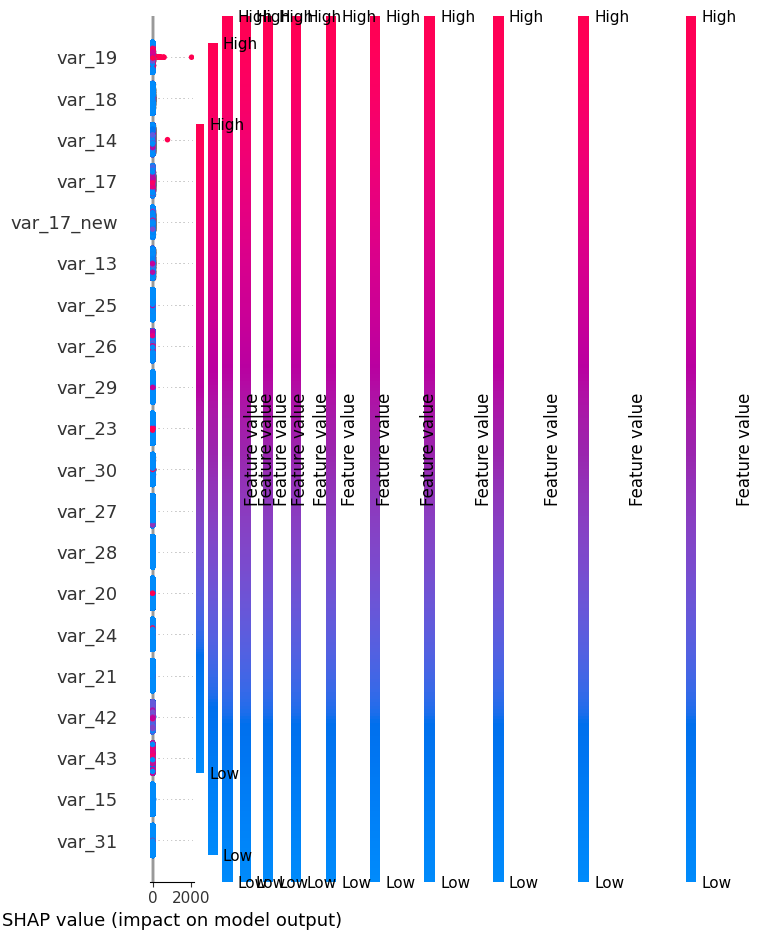

In [102]:
for col in interest_cols:
    explainer, Xs = shap_explainers_interest[col]
    shap_values = explainer.shap_values(Xs)

    print("\nSHAP summary for:", col)
    shap.summary_plot(shap_values, Xs, show=False)

Building SHAP summary plot for redemption model...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


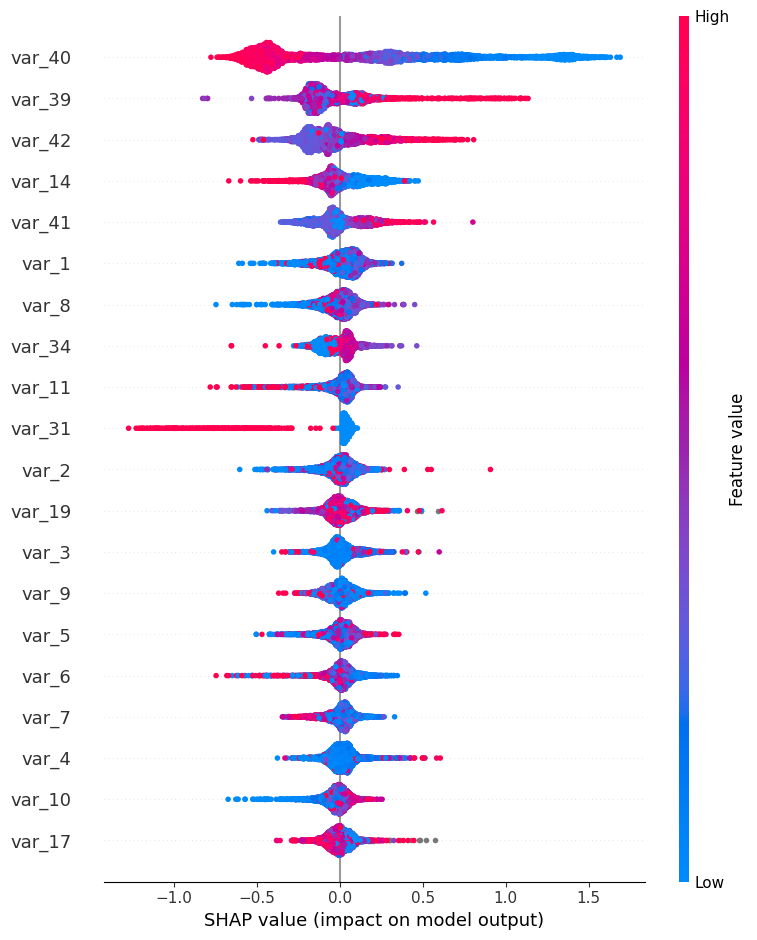

In [105]:
print("Building SHAP summary plot for redemption model...")

shap_values_clf = explainer_clf.shap_values(X_sample_clf)

# --- FIX START ---
# SHAP output can be:
# 1) list of arrays (binary/multiclass)
# 2) a single 2D matrix (regression-like classifier)
if isinstance(shap_values_clf, list):
    # use class 1 = positive (redeem)
    shap_matrix = shap_values_clf[1]
else:
    # direct matrix (n , features)
    shap_matrix = shap_values_clf
# --- FIX END ---

shap.summary_plot(shap_matrix, X_sample_clf)


In [106]:
def get_shap_matrix(shap_out, positive_class_index=1):
    """
    shap_out may be:
      - a list of arrays (one per class) -> return shap_out[positive_class_index]
      - a single array (n_samples, n_features) -> return it
    """
    if isinstance(shap_out, list):
        # for binary classification, positive_class_index = 1
        return shap_out[positive_class_index]
    else:
        return shap_out


In [107]:
import shap, numpy as np, matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def plot_shap_waterfall_for_row(row, explainer, clf_feature_list, show=True, save_path=None):
    """
    row: pandas Series or 1-row DataFrame that contains features in clf_feature_list
    explainer: shap.TreeExplainer for classifier
    """
    # prepare row in correct order
    X_row = row[clf_feature_list].values.reshape(1, -1)
    shap_out = explainer.shap_values(X_row)
    shap_matrix = get_shap_matrix(shap_out)
    # shap.force_plot -> returns html or matplotlib object; use matplotlib renderer:
    base_value = explainer.expected_value
    if isinstance(base_value, list):
        expected = base_value[1]
    else:
        expected = base_value
    # shap.force_plot supports matplotlib=True to return Matplotlib figure
    fp = shap.force_plot(expected, shap_matrix[0,:], row[clf_feature_list], matplotlib=True, show=False)
    if save_path:
        plt.savefig(save_path, dpi=200)
    if show:
        plt.show()
    plt.close()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


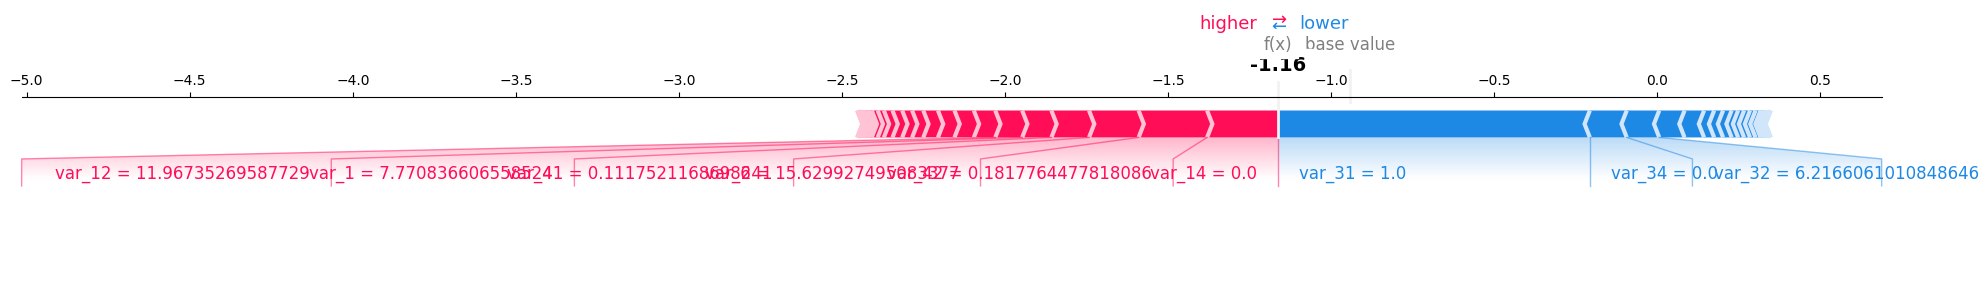

In [109]:
# row must be a Series with clf_feature_list columns (e.g., from df_pred)
row = df_pred.loc[1]   # single customer-offer row
plot_shap_waterfall_for_row(row, explainer_clf, clf_feature_list, save_path="waterfall.png")

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_offers_shap(customer_row, offers_df, explainer, clf_feature_list, top_k=10, save_path=None, show=True):
    """
    customer_row: Series of customer features (may not include offer-specific features)
    offers_df: DataFrame with one row per offer and offer-specific columns (must include encoded offer_id or same feature columns)
    explainer: shap.TreeExplainer
    """
    frames = []
    for _, offer in offers_df.iterrows():
        # build full candidate row dict containing exactly clf_feature_list
        cand = {}
        for c in clf_feature_list:
            if c in offer:
                cand[c] = offer[c]
            elif c in customer_row:
                cand[c] = customer_row[c]
            else:
                cand[c] = 0
        cand = pd.Series(cand)
        X = cand[clf_feature_list].values.reshape(1, -1)
        shap_out = explainer.shap_values(X)
        shap_vector = get_shap_matrix(shap_out)[0]
        df_sh = pd.DataFrame({
            "feature": clf_feature_list,
            "shap_value": shap_vector
        })
        df_sh["offer_id"] = offer.get("offer_id", offer.get("offer_id_encoded", "unknown"))
        # top features by abs
        df_sh = df_sh.assign(abs_shap = df_sh["shap_value"].abs()).sort_values("abs_shap", ascending=False).head(top_k)
        frames.append(df_sh)
    # Plot each in separate subplot
    n = len(frames)
    fig, axes = plt.subplots(nrows=n, figsize=(8, 3*n))
    if n == 1:
        axes = [axes]
    for ax, df_sh in zip(axes, frames):
        df_sh_sorted = df_sh.sort_values("shap_value")
        ax.barh(df_sh_sorted["feature"], df_sh_sorted["shap_value"])
        ax.set_title(f"Offer {df_sh['offer_id'].iloc[0]} - top {top_k} SHAP")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    if show:
        plt.show()
    plt.close()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


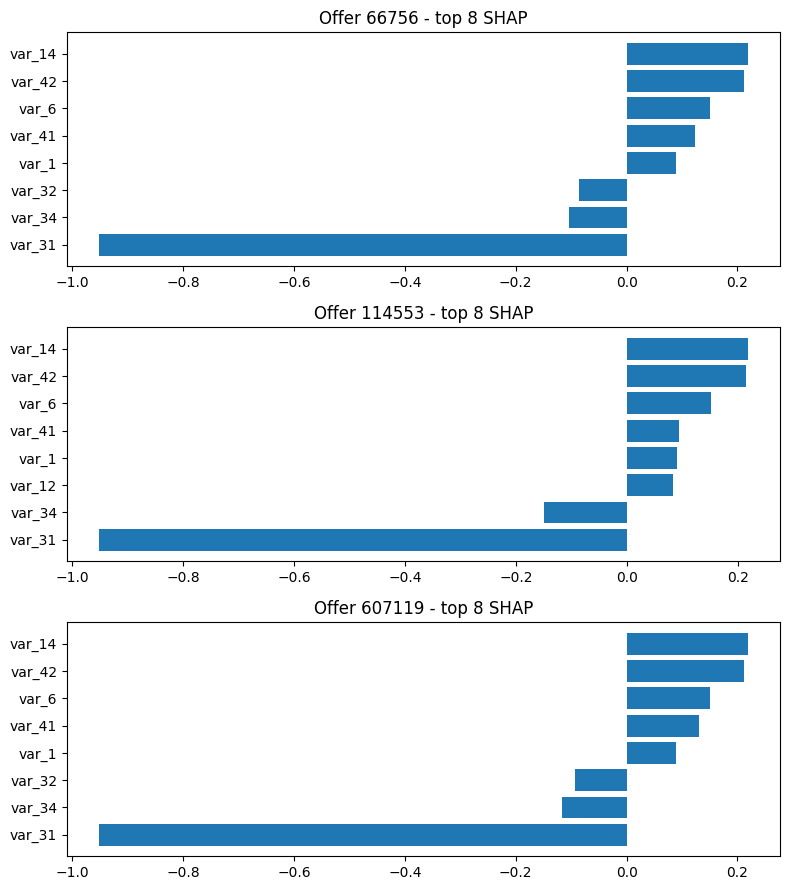

In [111]:
# offers_df needs at least the offer features + offer_id (or encoded)
offers_subset = offers_unique.sample(3, random_state=1)   # pick 3 offers to compare
compare_offers_shap(customer, offers_subset, explainer_clf, clf_feature_list, top_k=8, save_path="compare_offers.png")


In [112]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from io import BytesIO

def generate_customer_pdf_report(customer_idx, filename="customer_report.pdf", top_k_offers=3):
    customer = df_pred.iloc[customer_idx]
    # get recommendations
    offers_unique = df[["offer_id"] + offer_features].drop_duplicates().reset_index(drop=True)
    top = recommend_k(customer, offers_unique, k=top_k_offers)
    # prepare PDF
    with PdfPages(filename) as pdf:
        # Page 1: header + interest vector
        fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4
        ax.axis("off")
        ax.text(0.5, 0.95, f"Customer Report - index {customer_idx}", ha='center', fontsize=16, weight='bold')
        # interest barplot
        interests = customer[interest_cols].astype(float)
        ax_bar = fig.add_axes([0.1, 0.45, 0.8, 0.4])
        interests.plot(kind='bar', ax=ax_bar)
        ax_bar.set_title("Predicted Interest Scores")
        pdf.savefig(fig)
        plt.close()
        # Page 2..N: one page per offer explanation
        for i, row in top.reset_index(drop=True).iterrows():
            offer_id = row["offer_id"]
            # build candidate row
            offer_row = offers_unique[offers_unique["offer_id"] == offer_id].iloc[0]
            cand = {}
            for c in clf_feature_list:
                if c in offer_row:
                    cand[c] = offer_row[c]
                elif c in customer:
                    cand[c] = customer[c]
                else:
                    cand[c] = 0
            cand = pd.Series(cand)
            # produce SHAP figure
            X_row = cand[clf_feature_list].values.reshape(1, -1)
            shap_out = explainer_clf.shap_values(X_row)
            shap_matrix = get_shap_matrix(shap_out)
            expected = explainer_clf.expected_value[1] if isinstance(explainer_clf.expected_value, list) else explainer_clf.expected_value
            fig2 = shap.force_plot(expected, shap_matrix[0], cand[clf_feature_list], matplotlib=True, show=False)
            pdf.savefig(fig2)
            plt.close()
            # Add a metadata page with top features and numeric values
            fig3, ax3 = plt.subplots(figsize=(8.27, 11.69))
            ax3.axis("off")
            ax3.text(0.5, 0.95, f"Offer {offer_id} - score {row['score']:.4f}", ha='center', fontsize=14)
            # feature table: top 15 absolute shap contributors
            shap_vals = shap_matrix[0]
            df_sh = pd.DataFrame({"feature": clf_feature_list, "shap_value": shap_vals})
            df_sh["abs"] = df_sh["shap_value"].abs()
            df_sh = df_sh.sort_values("abs", ascending=False).head(15).reset_index(drop=True)
            table = ax3.table(cellText=df_sh.values, colLabels=df_sh.columns, loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(8)
            table.scale(1, 1.5)
            pdf.savefig(fig3)
            plt.close()
    print(f"Saved customer report: {filename}")


In [113]:
generate_customer_pdf_report(customer_idx=0, filename="cust0_report.pdf", top_k_offers=3)
# opensaved file in working directory

KeyError: 'offer_id_encoded'

In [116]:
def explain_customer_interest(customer_row):
    """
    Returns top-10 feature SHAP contributions for EACH interest score (var_1..var_12)
    for a given customer row.

    Output:
        {
           "var_1": DataFrame(top 10 shap contributions),
           "var_2": DataFrame(top 10),
           ...
        }
    """
    explanations = {}

    # use only numeric features (used to train interest models)
    X_row = customer_row[numeric_features].values.reshape(1, -1)

    feature_names = numeric_features  # for DataFrame output

    for col in interest_cols:
        explainer, Xs_sample = shap_explainers_interest[col]

        shap_out = explainer.shap_values(X_row)

        # SHAP can return vector or matrix → normalize
        if isinstance(shap_out, list):
            # regression returns a single element list in older SHAP versions
            shap_vec = shap_out[0].flatten()
        else:
            # single row: (1, n_features)
            shap_vec = shap_out.flatten()

        # build importance table
        df_imp = pd.DataFrame({
            "feature": feature_names,
            "shap_value": shap_vec,
            "abs_value": np.abs(shap_vec)
        }).sort_values("abs_value", ascending=False)

        explanations[col] = df_imp.head(10)

    return explanations


In [117]:
customer = df_pred.iloc[123]   # pick any customer
interest_expl = explain_customer_interest(customer)

# Top features for var_1
interest_expl["var_1"]


,feature,shap_value,abs_value
1,var_14,-2.683890,2.683890
5,var_18,-1.394458,1.394458
12,var_25,0.842168,0.842168
38,var_17_new,0.644961,0.644961
14,var_27,-0.532896,0.532896
11,var_24,-0.494963,0.494963
13,var_26,0.359003,0.359003
0,var_13,0.327227,0.327227
16,var_29,-0.322321,0.322321
7,var_20,-0.207429,0.207429


In [118]:
def plot_interest_waterfall(customer_row, interest_var):
    model = interest_models[interest_var]
    explainer, _ = shap_explainers_interest[interest_var]

    X_row = customer_row[numeric_features].values.reshape(1, -1)
    shap_out = explainer.shap_values(X_row)

    shap_vec = shap_out[0] if isinstance(shap_out, list) else shap_out

    expected = explainer.expected_value
    shap.force_plot(
        expected,
        shap_vec,
        customer_row[numeric_features],
        matplotlib=True,
        show=True
    )


In [126]:
def explain_redemption(row):
    """
    row: a pandas Series containing at least all clf_feature_list columns.
    Returns: Top 15 SHAP contributions for that offer-customer row.
    """

    # 1. Convert Series -> 1-row DataFrame
    df_row = pd.DataFrame([row])

    # 2. Ensure all classifier features exist in correct order
    for c in clf_feature_list:
        if c not in df_row.columns:
            df_row[c] = 0  # add missing

    df_row = df_row[clf_feature_list]

    # 3. Force numeric dtype (float)
    df_row = df_row.astype(float)

    # 4. SHAP calculation
    shap_out = explainer_clf.shap_values(df_row)

    # 5. Normalize SHAP output (binary vs single-matrix)
    if isinstance(shap_out, list):
        shap_vec = shap_out[1][0]   # class=1
    else:
        shap_vec = shap_out[0]

    # 6. Build explanation table
    df_exp = pd.DataFrame({
        "feature": clf_feature_list,
        "value": df_row.iloc[0].values,
        "shap_value": shap_vec,
        "abs_value": np.abs(shap_vec)
    }).sort_values("abs_value", ascending=False)

    return df_exp.head(15)


In [127]:
first_offer = top3.iloc[0]["offer_id"]
offer_row = df_pred[df_pred["offer_id"] == first_offer].iloc[0]

explanation = explain_redemption(offer_row)
print(explanation)


             feature       value  shap_value  abs_value
27            var_40   59.000000    1.479215   1.479215
40             var_2    3.595956   -0.193168   0.193168
28            var_41    0.176829    0.164380   0.164380
21            var_34    5.420535   -0.148146   0.148146
51  offer_id_encoded  188.000000    0.116056   0.116056
26            var_39   79.000000    0.094974   0.094974
46             var_8   21.353792    0.085154   0.085154
4             var_17    7.766586   -0.083545   0.083545
42             var_4    3.943710   -0.082113   0.082113
30            var_43    0.000000    0.071520   0.071520
39             var_1   18.425138    0.069485   0.069485
6             var_19    5.350056   -0.067602   0.067602
44             var_6   31.850598   -0.056255   0.056255
50            var_12   26.347096    0.056239   0.056239
45             var_7   19.405091    0.044648   0.044648


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [128]:
shap.force_plot(
    explainer_clf.expected_value[1],
    shap_value,
    X_row,
    matplotlib=True
)


IndexError: invalid index to scalar variable.

In [129]:
def fix_input_row(row, clf_feature_list):
    """
    Ensures row:
    - is a DataFrame
    - has ALL clf features
    - columns are in correct order
    - dtype is numeric (float)
    """
    # Convert Series → DataFrame
    df_row = pd.DataFrame([row]) if isinstance(row, pd.Series) else row.copy()

    # Add missing columns
    for c in clf_feature_list:
        if c not in df_row.columns:
            df_row[c] = 0

    # Keep only model features, in the correct order
    df_row = df_row[clf_feature_list]

    # Convert all to float
    df_row = df_row.astype(float)

    return df_row


In [130]:
def normalize_shap_output(shap_output):
    """
    SHAP for LightGBM can return:
    - list of arrays (binary/multiclass)
    - single 2D array

    Returns a 1D vector of shap values for the positive class.
    """
    if isinstance(shap_output, list):
        # binary → class 1 = positive (redeem)
        return shap_output[1][0]
    else:
        # already matrix → take first row
        return shap_output[0]


In [131]:
def unified_offer_explanation(customer_row, offer_row):
    """
    Inputs:
        customer_row : Series containing user/customer features
        offer_row    : Series containing offer features (must include offer_id_encoded)

    Outputs a dictionary:
    {
        "offer_id": "...",
        "probability": float,
        "top_positive": [...],
        "top_negative": [...],
        "all_features": [...],
        "raw_shap": { feature: shap_value },
        "sorted_shap": [ (feature, shap, abs_shap) ],
        "expected_value": float
    }
    """

    # Step 1 — Build combined customer+offer row
    combined = {}
    for c in clf_feature_list:
        if c in offer_row:
            combined[c] = offer_row[c]
        elif c in customer_row:
            combined[c] = customer_row[c]
        else:
            combined[c] = 0

    combined = pd.Series(combined)

    # Step 2 — Fix dtypes, ordering, missing columns
    X_row = fix_input_row(combined, clf_feature_list)

    # Step 3 — Predict redemption probability
    probability = float(clf.predict_proba(X_row)[0][1])

    # Step 4 — SHAP values
    shap_raw = explainer_clf.shap_values(X_row)
    shap_vec = normalize_shap_output(shap_raw)

    # Expected value
    if isinstance(explainer_clf.expected_value, list):
        expected = float(explainer_clf.expected_value[1])
    else:
        expected = float(explainer_clf.expected_value)

    # Step 5 — Build feature importance table
    df_exp = pd.DataFrame({
        "feature": clf_feature_list,
        "value": X_row.iloc[0].values,
        "shap": shap_vec,
        "abs_shap": np.abs(shap_vec)
    }).sort_values("abs_shap", ascending=False)

    # Top + / - drivers
    top_positive = df_exp[df_exp["shap"] > 0].head(10)
    top_negative = df_exp[df_exp["shap"] < 0].head(10)

    # Convert to JSON-friendly format
    output = {
        "offer_id": offer_le.inverse_transform([int(offer_row["offer_id_encoded"])])[0]
                    if "offer_id_encoded" in offer_row else offer_row.get("offer_id"),

        "probability": probability,

        "top_positive": top_positive[["feature", "shap", "value"]].to_dict("records"),
        "top_negative": top_negative[["feature", "shap", "value"]].to_dict("records"),

        "all_features": df_exp.to_dict("records"),
        "raw_shap": {f: float(s) for f, s in zip(clf_feature_list, shap_vec)},
        "sorted_shap": df_exp[["feature","shap","abs_shap"]].head(30).to_dict("records"),

        "expected_value": expected
    }

    return output


In [138]:
customer = df_pred.iloc[3123]   # pick some customer
offer = offers_unique.iloc[3]  # pick some offer
print(customer)
exp = unified_offer_explanation(customer, offer)

import json
print(json.dumps(exp, indent=2))


customer_id                            1390695
offer_id                                 25749
event_ts            2023-11-14 14:30:25.979000
event_dt                   2023-11-14 00:00:00
offer_action                                 0
var_1                                22.600695
var_2                                36.477745
var_3                                 4.257284
var_4                                  0.72517
var_5                                13.193532
var_6                                 38.35949
var_7                                25.956096
var_8                                42.835327
var_9                                35.974421
var_10                               33.005499
var_11                               22.334336
var_12                               25.104159
var_13                                    36.0
var_14                                     3.0
var_15                                     0.0
var_16                                     0.0
var_17       

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [141]:
df_pred

,customer_id,offer_id,event_ts,event_dt,offer_action,var_1,var_2,var_3,var_4,var_5,...,var_44,var_45,var_46,var_47,var_48,var_49,var_50,event_ts_clean,var_17_new,offer_id_encoded
0,1010494,601711,2023-11-01 10:25:21.000904,2023-11-01,1,9.236018,5.737339,2.503810,1.134259,21.831386,...,0,0,0,0,0,1,0,2023-11-01 10:25:21.000904,57.24,390
1,1010494,33452,2023-11-09 08:37:35.165000,2023-11-09,0,7.770837,4.877395,2.034221,1.033896,10.462358,...,0,0,0,0,0,1,0,2023-11-09 08:37:35.165000,57.24,206
2,1010494,88456737,2023-11-01 10:15:55.000489,2023-11-01,1,9.392516,5.692365,2.613142,1.122882,21.794177,...,0,0,0,0,0,1,0,2023-11-01 10:15:55.000489,57.24,707
3,1010494,390981,2023-11-01 10:27:27.000313,2023-11-01,1,9.373623,5.737339,2.555467,1.122882,21.961179,...,0,0,0,0,0,1,0,2023-11-01 10:27:27.000313,57.24,242
4,1010494,7114,2023-11-09 08:37:38.553000,2023-11-09,0,7.713613,4.877395,2.034221,1.033896,10.800066,...,0,0,0,0,0,1,0,2023-11-09 08:37:38.553000,57.24,513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004795,1747669,4489,2023-11-06 12:27:00.000000,2023-11-06,0,3.312647,14.174231,2.303665,-0.444950,28.452604,...,0,0,0,0,0,1,0,06 Nov 2023 12:27,500.45,283
2004796,1125867,118034590,2023-11-05 15:17:02.000994,2023-11-05,1,8.916096,7.316511,2.127167,3.563741,29.862334,...,0,0,0,0,0,1,0,2023-11-05 15:17:02.000994,2215.47,9
2004801,1504094,38388560,2023-11-15 15:49:06.000000,2023-11-15,0,10.677169,11.634679,1.150325,5.106289,21.185037,...,0,0,0,0,0,1,0,2023-11-15 15:49:06,2264.70,240
2004805,1102004,338083,2023-11-15 10:35:00.000000,2023-11-15,0,15.600244,16.527457,4.713481,2.378230,24.559072,...,0,0,0,0,0,1,0,15 Nov 2023 10:35,0.00,207


In [157]:
interest_cols = [f"var_{i}" for i in range(1, 13)]

df_avg = df_pred.groupby("customer_id")[interest_cols].mean().round(0).reset_index()


In [158]:
df_avg

,customer_id,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12
0,1000125,9.0,28.0,4.0,2.0,25.0,27.0,33.0,31.0,-0.0,27.0,17.0,22.0
1,1000164,8.0,9.0,4.0,1.0,41.0,42.0,23.0,24.0,14.0,32.0,19.0,33.0
2,1000186,8.0,22.0,2.0,1.0,14.0,31.0,34.0,30.0,20.0,9.0,15.0,29.0
3,1000276,25.0,13.0,4.0,1.0,33.0,35.0,18.0,30.0,18.0,22.0,18.0,31.0
4,1000331,13.0,14.0,3.0,2.0,25.0,35.0,15.0,28.0,2.0,21.0,17.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1910212,15.0,45.0,24.0,1.0,34.0,76.0,75.0,81.0,3.0,66.0,72.0,69.0
9996,1910264,9.0,27.0,2.0,2.0,75.0,72.0,30.0,37.0,-0.0,71.0,25.0,83.0
9997,1910382,6.0,27.0,2.0,1.0,48.0,74.0,73.0,45.0,0.0,43.0,45.0,83.0
9998,1910461,16.0,20.0,52.0,35.0,38.0,74.0,46.0,46.0,-0.0,89.0,57.0,67.0


In [159]:
df_avg

,customer_id,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12
0,1000125,9.0,28.0,4.0,2.0,25.0,27.0,33.0,31.0,-0.0,27.0,17.0,22.0
1,1000164,8.0,9.0,4.0,1.0,41.0,42.0,23.0,24.0,14.0,32.0,19.0,33.0
2,1000186,8.0,22.0,2.0,1.0,14.0,31.0,34.0,30.0,20.0,9.0,15.0,29.0
3,1000276,25.0,13.0,4.0,1.0,33.0,35.0,18.0,30.0,18.0,22.0,18.0,31.0
4,1000331,13.0,14.0,3.0,2.0,25.0,35.0,15.0,28.0,2.0,21.0,17.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1910212,15.0,45.0,24.0,1.0,34.0,76.0,75.0,81.0,3.0,66.0,72.0,69.0
9996,1910264,9.0,27.0,2.0,2.0,75.0,72.0,30.0,37.0,-0.0,71.0,25.0,83.0
9997,1910382,6.0,27.0,2.0,1.0,48.0,74.0,73.0,45.0,0.0,43.0,45.0,83.0
9998,1910461,16.0,20.0,52.0,35.0,38.0,74.0,46.0,46.0,-0.0,89.0,57.0,67.0


In [160]:
df_finalscore=df_avg

In [161]:
df_finalscore[df_finalscore["customer_id"]=="1014097"]

,customer_id,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12
123,1014097,9.0,6.0,0.0,1.0,58.0,25.0,11.0,15.0,0.0,15.0,15.0,20.0


In [162]:
df_finalscore.to_csv("customer_interest_averages.csv", index=False)